In [43]:
import pandas as pd
pd.set_option('display.max_rows', 500) 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from sklearn.metrics import  mean_squared_error
import numpy as np
from tqdm import tqdm

from collections import defaultdict

from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader, random_split

from torchsummary import summary

#add utils module to sys path
import sys
sys.path.append('../')
pd.option_context('mode.use_inf_as_na', True)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
root = os.getcwd()
print(root)

e:\ML\NLP\UB DL\assignment1\part3\new


In [3]:
dataset_path = os.path.join(root, 'dataset/retail_dataset')
assert(os.path.exists(dataset_path)), 'path to dataset not found'

features_df = pd.read_csv(os.path.join(dataset_path, 'features.csv'))
sales_df = pd.read_csv(os.path.join(dataset_path, 'sales.csv'))
stores_df = pd.read_csv(os.path.join(dataset_path, 'stores.csv'))

In [4]:
print(features_df.shape)
features_df.head()

(8190, 12)


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [5]:
print(sales_df.shape)
sales_df.head()

(421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


### Do some data analysis and EDA

In [6]:
def extract_detail_datetime(datetime_fmt):
    day, month, year = datetime_fmt.split("/")
    month = int(month)
    day = int(day)
    year = int(year)

    dt = datetime(
        month = month,
        day = day,
        year = year,
    )

    return month, day, year, dt.timestamp()

In [7]:
date_col = sales_df['Date']
month_col = []
day_col = []
year_col = []
timestamp_col = []

for row in date_col:
    month, day, year, timestamp = extract_detail_datetime(row)
    month_col.append(month)
    day_col.append(day)
    year_col.append(year)
    timestamp_col.append(timestamp)

sales_df['Month'] = month_col
sales_df['Day'] = day_col
sales_df['Year'] = year_col
sales_df['Timestamp'] = timestamp_col

sales_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Month,Day,Year,Timestamp
0,1,1,05/02/2010,24924.50,False,2,5,2010,1.265346e+09
1,1,1,12/02/2010,46039.49,True,2,12,2010,1.265951e+09
2,1,1,19/02/2010,41595.55,False,2,19,2010,1.266556e+09
3,1,1,26/02/2010,19403.54,False,2,26,2010,1.267160e+09
4,1,1,05/03/2010,21827.90,False,3,5,2010,1.267765e+09


In [8]:
print(set(sales_df['Dept'].values))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 58, 59, 60, 65, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}


c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


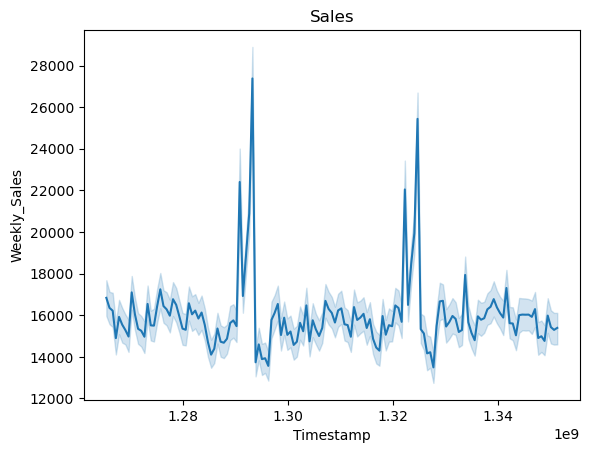

In [9]:
sns.lineplot(sales_df, x = 'Timestamp', y = 'Weekly_Sales')
plt.title("Sales")
plt.show()

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


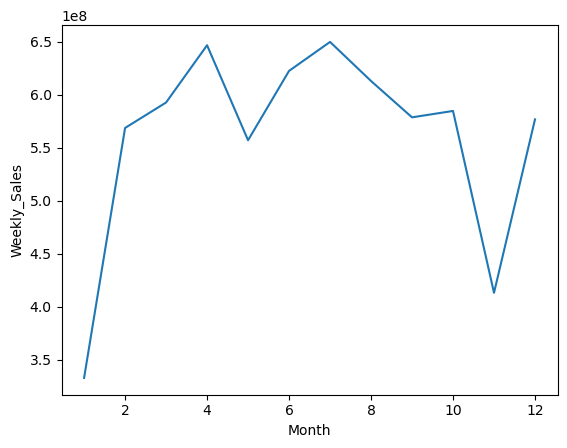

In [10]:
sales_groupby_month = sales_df.groupby('Month').sum()
sales_groupby_month.head()
sns.lineplot(sales_groupby_month, x = sales_groupby_month.index, y = 'Weekly_Sales')
plt.show("Weekly Sales by Month")

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


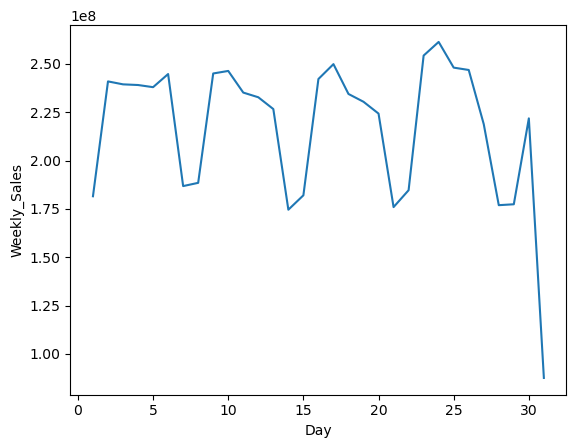

In [11]:
sales_groupby_day_of_month = sales_df.groupby('Day').sum()
sales_groupby_day_of_month.head()
sns.lineplot(sales_groupby_day_of_month, x = sales_groupby_day_of_month.index, y = 'Weekly_Sales')
plt.show("Weekly Sales by Day of Month")

### Quick RNN baseline

In [12]:
cols = sales_df.columns
print(cols)

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Month', 'Day',
       'Year', 'Timestamp'],
      dtype='object')


In [13]:
feature_cols = [ 'Dept', 'Weekly_Sales', 'IsHoliday', 'Timestamp']
target = 'Weekly_Sales'
train_df = sales_df[feature_cols].copy()
train_df['IsHoliday'] = train_df['IsHoliday'].map({True: 1, False: 0})

train_df = (train_df - train_df.min())/ (train_df.max() - train_df.min())
features = train_df.drop('Timestamp',  axis = 1)
labels = train_df[target]

print(features.shape)
print(features.head())
print(labels.shape)
print(labels.head())

(421570, 3)
   Dept  Weekly_Sales  IsHoliday
0   0.0      0.042851        0.0
1   0.0      0.073097        1.0
2   0.0      0.066732        0.0
3   0.0      0.034942        0.0
4   0.0      0.038415        0.0
(421570,)
0    0.042851
1    0.073097
2    0.066732
3    0.034942
4    0.038415
Name: Weekly_Sales, dtype: float64


In [14]:
class RetailDataset(Dataset):
    def __init__(self, X, y) -> None:
        super().__init__()
        self.X, self.y = X, y 
    
    def __len__(self):
        return len(self.X)
    
    def get_dataloader(self, **kwargs):
        return DataLoader(self, **kwargs)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]


In [15]:
def create_dataset(features, labels, timestep):
    """
    @params:
        df: pandas.DataFrame. Dataset 
        timestep: int, timestep for each datapoint
    @returns
        X: torch.tensor, feature shape of (timestep, # features)
        y: torch.tensor, label shape of (timestep,)

    """
    X, y = [], []
    features = features.to_numpy()
    labels = labels.to_numpy()
    N = len(features)
    for i in range(N-timestep):
        X.append(features[i:i+timestep])
        y.append(labels[i+1:i+timestep+1])
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)



In [16]:
BATCH_SIZE = 256
TIME_STEP = 10

In [17]:
X,y = create_dataset(features, labels, timestep=TIME_STEP)
dataset = RetailDataset(X, y)

C:\Users\nguye\AppData\Local\Temp\ipykernel_11040\1169873869.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [18]:
total_len = len(dataset)
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

train_size = int(total_len * train_ratio)
valid_size = int(total_len * valid_ratio)
test_size = int(total_len * test_ratio)

print('total len = ', total_len)
print()

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])
print('train dataset len = ', len(train_dataset))
print('valid dataset len = ', len(valid_dataset))
print('test dataset len = ', len(test_dataset))

train_dataloader =  DataLoader(train_dataset, shuffle= True, batch_size = BATCH_SIZE)
val_dataloader =  DataLoader(valid_dataset, shuffle= True, batch_size = BATCH_SIZE)
test_dataloader =  DataLoader(test_dataset, shuffle= True, batch_size = BATCH_SIZE)
print('train dataloader len = ', len(train_dataloader))
print('valid dataloader len = ', len(val_dataloader))
print('test dataloader len = ', len(test_dataloader))

total len =  421560

train dataset len =  295092
valid dataset len =  63234
test dataset len =  63234
train dataloader len =  1153
valid dataloader len =  248
test dataloader len =  248


In [19]:
y_test = torch.tensor([])
for X,y in test_dataloader:
    y_test = torch.cat((y_test, y[:,-1]))
print('y test shape = ', y_test.shape)
print(y_test)

y test shape =  torch.Size([63234])
tensor([0.0078, 0.0457, 0.0877,  ..., 0.0073, 0.3895, 0.0129])


In [20]:
y_val = torch.tensor([])
for X,y in val_dataloader:
    y_val = torch.cat((y_val, y[:,-1]))
print('y test shape = ', y_val.shape)
print(y_val)

y test shape =  torch.Size([63234])
tensor([0.0206, 0.0190, 0.0419,  ..., 0.0264, 0.0195, 0.0626])


In [21]:
sampleX, sampleY = next(iter(train_dataloader))
print(sampleX.shape)
print(sampleX[0])
print(sampleY.shape)
print(sampleY[0])

torch.Size([256, 10, 3])
tensor([[0.0510, 0.0132, 0.0000],
        [0.0510, 0.0122, 0.0000],
        [0.0510, 0.0360, 1.0000],
        [0.0510, 0.0163, 0.0000],
        [0.0510, 0.0164, 0.0000],
        [0.0510, 0.0244, 0.0000],
        [0.0510, 0.0480, 0.0000],
        [0.0510, 0.0156, 1.0000],
        [0.0510, 0.0091, 0.0000],
        [0.0510, 0.0105, 0.0000]])
torch.Size([256, 10])
tensor([0.0122, 0.0360, 0.0163, 0.0164, 0.0244, 0.0480, 0.0156, 0.0091, 0.0105,
        0.0102])


In [22]:
class RNNBinaryClassification(nn.Module):
  def __init__(self, input_dim,hidden_dim = 200, num_layers= 3):
    super(RNNBinaryClassification, self).__init__()
    self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.LazyLinear(2)

  def forward(self, x):
    outputs, state = self.rnn(x)
    # Get the output of the last time step
    return self.fc(outputs)
  
class RNNRegression(nn.Module):
  def __init__(self, input_dim,hidden_dim = 200, num_layers= 3):
    super(RNNRegression, self).__init__()
    self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.LazyLinear(1)

  def forward(self, x):
    outputs, state = self.rnn(x)
    # Get the output of the last time step
    return self.fc(outputs)

In [23]:
sampleX, sampley = next(iter(train_dataloader))
print('X shape = ', sampleX.shape, ' dtype = ', sampleX.dtype)
print('y shape = ', sampley.shape, ' dtype = ', sampley.dtype)
batch_size, num_steps, input_dim = sampleX.shape

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = RNNRegression(input_dim=input_dim)

y_pred = model(sampleX)
y_pred = y_pred.squeeze(-1)
print('y pred shape = ', y_pred.shape)

loss_fn = nn.MSELoss()

loss = loss_fn(y_pred, sampley.to(torch.long))
print(loss.item())


X shape =  torch.Size([256, 10, 3])  dtype =  torch.float32
y shape =  torch.Size([256, 10])  dtype =  torch.float32
y pred shape =  torch.Size([256, 10])
0.000880912528373301


c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [27]:
def score(score_fn, model, dataloader, device, criterion, **kwargs):
    y_pred = torch.tensor([])
    y = torch.tensor([])
    loop = tqdm(dataloader)
    running_loss = 0.0
    total_samples = 0

    #set model eval
    model.eval()
    for batch in loop: 
        # features, labels = self.prepare_batch(batch, device)
        features,labels = batch
        features = features.to(device)
        labels = labels.to(device).to(torch.float32)
        total_samples += len(labels)

        outputs = model(features)
        outputs = outputs.squeeze(-1)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        y_pred = torch.cat((y_pred, outputs.detach().cpu()), dim = 0)
        y = torch.cat((y, labels.detach().cpu()), dim = 0)

    return score_fn(y.numpy(), y_pred.numpy()), running_loss

#test
val_score, val_loss = score(mean_squared_error, model, val_dataloader, device, loss_fn)

100%|██████████| 248/248 [00:01<00:00, 125.64it/s]


### Regression Task

In [48]:
def tune(model, train_dataloader, val_dataloader, test_dataloader, optim, loss_fn, device):
    # batch_size, num_steps, input_dim = sampleX.shape

    # model = RNNRegression(input_dim=input_dim, hidden_dim = 500, num_layers = 5)
    # model.to(device)

    # optim = torch.optim.Adam(model.parameters(), lr = 0.00001)
    # loss_fn = nn.MSELoss()

    best_loss = float('inf')

    history = defaultdict(list)

    for e in range(10):

        loop = tqdm(train_dataloader)
        running_loss = 0.0

        model.train()

        for X, y in loop:
            X= X.to(device)
            y = y.to(device).to(torch.float32)

            y_pred = model(X) 
            y_pred = y_pred.squeeze(-1)
            optim.zero_grad()
            loss = loss_fn(y_pred, y)
            running_loss += loss.item()

            loss.backward()
            optim.step()
            loop.set_description(f'epoch = {e}, running_loss = {running_loss:.2f}')

        train_score, train_loss = score(mean_squared_error, model, train_dataloader, device, loss_fn)
        val_score, val_loss = score(mean_squared_error, model, val_dataloader, device, loss_fn)
        test_score, test_loss = score(mean_squared_error, model, test_dataloader, device, loss_fn)

        history['train_score'].append(train_score),
        history['train_loss'].append(train_loss),
        history['val_score'].append(val_score),
        history['val_loss'].append(val_loss),
        history['test_score'].append(test_score),
        history['test_loss'].append(test_loss),
        print(f'epoch = {e}, train_score=  {train_score}, val_score= {val_score}, test_score= {test_score}')

    if best_loss > test_score:
        print('saved checkpoint')
        torch.save(model, 'rnn.regression.best.torch')
        best_loss = test_score 
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5)) 
    epochs = list(range(len(history['train_score'])))
    sns.lineplot(y = history["train_score"], label ='train MSE', x = epochs, ax = ax1)
    sns.lineplot(y = history["val_score"],   label ='val MSE', x = epochs, ax = ax1)
    sns.lineplot(y = history["val_score"],  label ='test MSE', x = epochs, ax = ax1)
    ax1.set_title("Accuracy")

    sns.lineplot(y = history["train_loss"], label ='train loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["val_loss"],   label ='val loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["test_loss"],  label ='test loss', x = epochs, ax = ax2)
    ax2.set_title("Loss")
    
    return history

Text(0.5, 1.0, 'Loss')

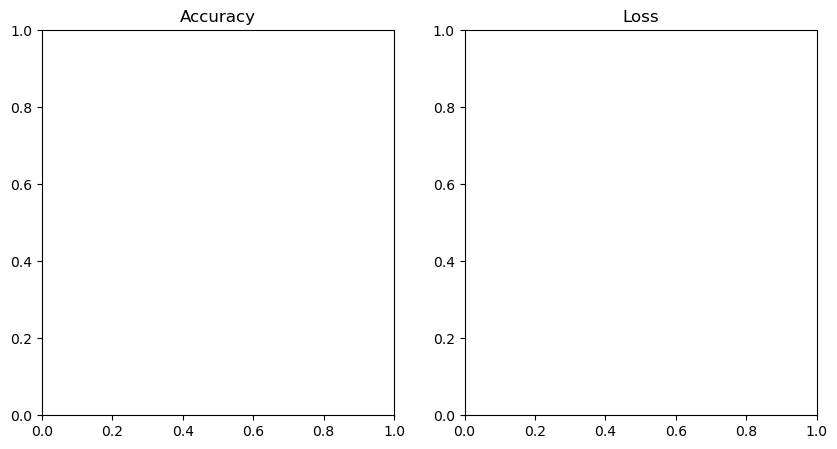

In [49]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5)) 
epochs = list(range(len(history['train_score'])))
sns.lineplot(y = history["train_score"], label ='train MSE', x = epochs, ax = ax1)
sns.lineplot(y = history["val_score"],   label ='val MSE', x = epochs, ax = ax1)
sns.lineplot(y = history["val_score"],  label ='test MSE', x = epochs, ax = ax1)
ax1.set_title("Accuracy")

sns.lineplot(y = history["train_loss"], label ='train loss', x = epochs, ax = ax2)
sns.lineplot(y = history["val_loss"],   label ='val loss', x = epochs, ax = ax2)
sns.lineplot(y = history["test_loss"],  label ='test loss', x = epochs, ax = ax2)
ax2.set_title("Loss")

# Baseline, 

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 248/248 [00:01<00:00, 153.62it/s]


epoch = 0, train_score=  0.0001485048996983096, val_score= 0.00013659815886057913, test_score= 0.0001560589298605919


100%|██████████| 248/248 [00:01<00:00, 157.63it/s]


epoch = 1, train_score=  0.00010558291978668422, val_score= 9.252307063434273e-05, test_score= 0.00011135391105199233


100%|██████████| 248/248 [00:01<00:00, 155.83it/s]


epoch = 2, train_score=  0.00010638228559400886, val_score= 9.319350647274405e-05, test_score= 0.00011220513988519087


100%|██████████| 248/248 [00:01<00:00, 152.61it/s]


epoch = 3, train_score=  0.00010503413068363443, val_score= 9.189259435515851e-05, test_score= 0.00011076495138695464


100%|██████████| 248/248 [00:01<00:00, 155.92it/s]


epoch = 4, train_score=  0.00010915314487647265, val_score= 9.599644545232877e-05, test_score= 0.00011489965254440904


100%|██████████| 248/248 [00:01<00:00, 144.47it/s]


epoch = 5, train_score=  0.00010849525278899819, val_score= 9.534684795653448e-05, test_score= 0.00011415201879572123


100%|██████████| 248/248 [00:01<00:00, 157.63it/s]


epoch = 6, train_score=  0.00010489744454389438, val_score= 9.182295616483316e-05, test_score= 0.00011062264820793644


100%|██████████| 248/248 [00:01<00:00, 160.85it/s]


epoch = 7, train_score=  0.00010530650615692139, val_score= 9.227755072060972e-05, test_score= 0.0001110381999751553


100%|██████████| 248/248 [00:01<00:00, 154.74it/s]


epoch = 8, train_score=  0.00010463135549798608, val_score= 9.153080463875085e-05, test_score= 0.00011036611249437556


100%|██████████| 248/248 [00:01<00:00, 157.42it/s]


epoch = 9, train_score=  0.00010422186460345984, val_score= 9.125384531216696e-05, test_score= 0.00010993875184794888
saved checkpoint


defaultdict(list,
            {'train_score': [0.0001485049,
              0.00010558292,
              0.000106382286,
              0.00010503413,
              0.000109153145,
              0.00010849525,
              0.000104897445,
              0.000105306506,
              0.000104631355,
              0.000104221865],
             'train_loss': [0.1712288354683551,
              0.12175641688554606,
              0.12272870043670991,
              0.12116535976565501,
              0.12588092307305487,
              0.12510024962102761,
              0.12096525972083327,
              0.1214434616122162,
              0.12067241716431454,
              0.1203615933754918],
             'val_score': [0.00013659816,
              9.252307e-05,
              9.319351e-05,
              9.1892594e-05,
              9.5996445e-05,
              9.534685e-05,
              9.1822956e-05,
              9.227755e-05,
              9.1530805e-05,
              9.1253845e-05],
         

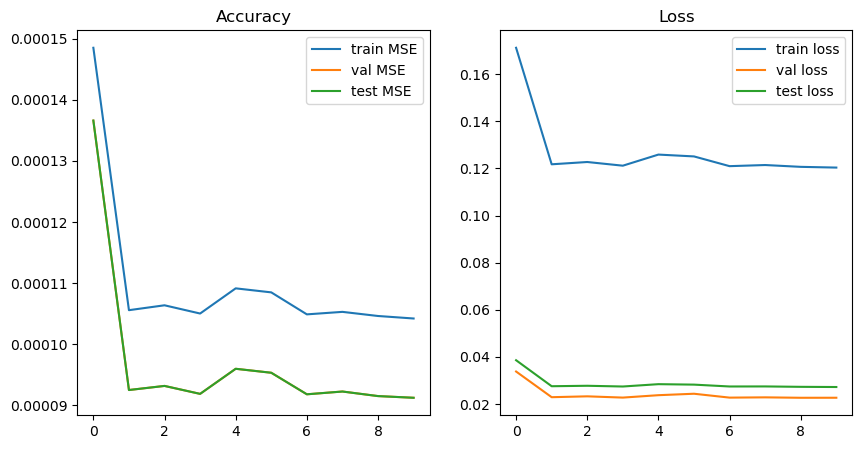

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size, num_steps, input_dim = sampleX.shape

model = RNNRegression(input_dim=input_dim, hidden_dim = 500, num_layers = 5)
model.to(device)

optim = torch.optim.Adam(model.parameters(), lr = 0.00001)
loss_fn = nn.MSELoss()

best_loss = float('inf')

history = defaultdict(list)

tune(model, train_dataloader, val_dataloader, test_dataloader, optim, loss_fn, device)

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 248/248 [00:02<00:00, 114.97it/s]


epoch = 0, train_score=  0.00010732274677138776, val_score= 9.445176692679524e-05, test_score= 0.00011315945448586717


100%|██████████| 248/248 [00:02<00:00, 117.73it/s]


epoch = 1, train_score=  0.00010730557551141828, val_score= 9.41449761739932e-05, test_score= 0.00011298565368633717


100%|██████████| 248/248 [00:02<00:00, 118.82it/s]


epoch = 2, train_score=  0.00010896369349211454, val_score= 9.576637239661068e-05, test_score= 0.00011470849858596921


100%|██████████| 248/248 [00:02<00:00, 117.96it/s]


epoch = 3, train_score=  0.00011087699385825545, val_score= 9.75906295934692e-05, test_score= 0.000116464972961694


100%|██████████| 248/248 [00:02<00:00, 119.19it/s]


epoch = 4, train_score=  0.00010585178097244352, val_score= 9.293753828387707e-05, test_score= 0.0001115028717322275


100%|██████████| 248/248 [00:02<00:00, 118.87it/s]


epoch = 5, train_score=  0.00010588495206320658, val_score= 9.303799015469849e-05, test_score= 0.00011154704407090321


100%|██████████| 248/248 [00:02<00:00, 112.41it/s]


epoch = 6, train_score=  0.0001051716972142458, val_score= 9.214253805112094e-05, test_score= 0.00011089634062955156


100%|██████████| 248/248 [00:02<00:00, 119.18it/s]


epoch = 7, train_score=  0.00010587686119833961, val_score= 9.249746653949842e-05, test_score= 0.00011172498489031568


100%|██████████| 248/248 [00:02<00:00, 117.99it/s]


epoch = 8, train_score=  0.00010690923954825848, val_score= 9.375374065712094e-05, test_score= 0.00011264742352068424


100%|██████████| 248/248 [00:02<00:00, 115.95it/s]


epoch = 9, train_score=  0.00010733343515312299, val_score= 9.425298048881814e-05, test_score= 0.00011301592167001218
saved checkpoint


defaultdict(list,
            {'train_score': [0.00010732275,
              0.000107305576,
              0.00010896369,
              0.000110876994,
              0.00010585178,
              0.00010588495,
              0.0001051717,
              0.00010587686,
              0.00010690924,
              0.000107333435],
             'train_loss': [0.12377860743254132,
              0.12372513386253559,
              0.1256829343674326,
              0.1278415784909157,
              0.12205797670139873,
              0.12210857708851108,
              0.12132593542810355,
              0.12210695670364657,
              0.12327943211130332,
              0.1237610525895434],
             'val_score': [9.445177e-05,
              9.4144976e-05,
              9.576637e-05,
              9.759063e-05,
              9.293754e-05,
              9.303799e-05,
              9.214254e-05,
              9.249747e-05,
              9.375374e-05,
              9.425298e-05],
             'val

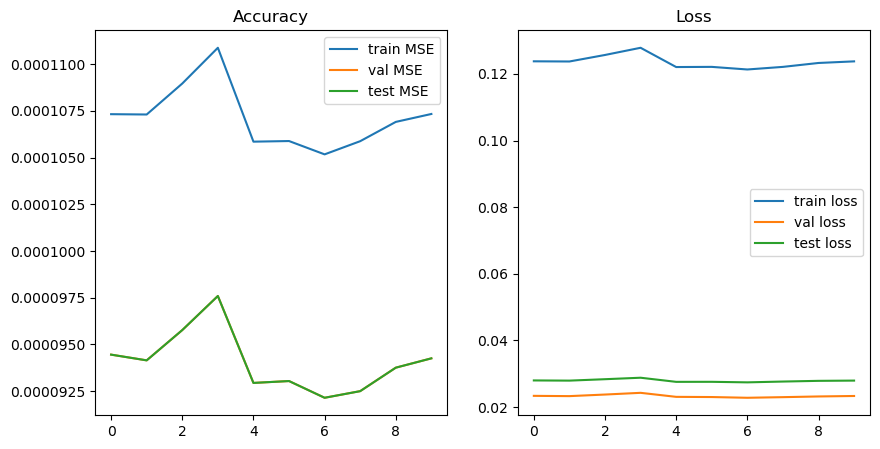

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size, num_steps, input_dim = sampleX.shape

model = RNNRegression(input_dim=input_dim, hidden_dim = 1000, num_layers = 5)
model.to(device)

optim = torch.optim.Adam(model.parameters(), lr = 0.00001)
loss_fn = nn.MSELoss()

best_loss = float('inf')

history = defaultdict(list)

tune(model, train_dataloader, val_dataloader, test_dataloader, optim, loss_fn, device)

In [ ]:
torch.save(model, 'rnn.regression.tune2.torch')

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  0%|          | 0/1153 [00:00<?, ?it/s]

100%|██████████| 248/248 [00:01<00:00, 166.03it/s]


epoch = 0, train_score=  0.00038060362567193806, val_score= 0.00036821450339630246, test_score= 0.00039136403938755393


100%|██████████| 248/248 [00:01<00:00, 168.10it/s]


epoch = 1, train_score=  0.00016460574988741428, val_score= 0.0001531839807284996, test_score= 0.00017256553110200912


100%|██████████| 248/248 [00:01<00:00, 162.05it/s]


epoch = 2, train_score=  9.992795821744949e-05, val_score= 8.81840314832516e-05, test_score= 0.00010530109284445643


100%|██████████| 248/248 [00:01<00:00, 172.36it/s]


epoch = 3, train_score=  9.854815289145336e-05, val_score= 8.691079710843042e-05, test_score= 0.00010378474689787254


100%|██████████| 248/248 [00:01<00:00, 160.59it/s]


epoch = 4, train_score=  9.696506458567455e-05, val_score= 8.554683881811798e-05, test_score= 0.0001020679046632722


100%|██████████| 248/248 [00:01<00:00, 169.91it/s]


epoch = 5, train_score=  9.549240348860621e-05, val_score= 8.428645378444344e-05, test_score= 0.00010043560905614868


100%|██████████| 248/248 [00:01<00:00, 168.98it/s]


epoch = 6, train_score=  9.478871652390808e-05, val_score= 8.36671533761546e-05, test_score= 9.959655290003866e-05


100%|██████████| 248/248 [00:01<00:00, 154.02it/s]


epoch = 7, train_score=  9.39489618758671e-05, val_score= 8.293761493405327e-05, test_score= 9.871829388430342e-05


100%|██████████| 248/248 [00:01<00:00, 168.01it/s]


epoch = 8, train_score=  9.395195229444653e-05, val_score= 8.296562737086788e-05, test_score= 9.858534758677706e-05


100%|██████████| 248/248 [00:01<00:00, 169.84it/s]


epoch = 9, train_score=  9.219572530128062e-05, val_score= 8.133950177580118e-05, test_score= 9.680252696853131e-05
saved checkpoint


defaultdict(list,
            {'train_score': [0.00038060363,
              0.00016460575,
              9.992796e-05,
              9.854815e-05,
              9.6965065e-05,
              9.54924e-05,
              9.478872e-05,
              9.394896e-05,
              9.395195e-05,
              9.2195725e-05],
             'train_loss': [0.4388535508624045,
              0.18985378418437904,
              0.11535716500293347,
              0.11364886171759281,
              0.11183444559901545,
              0.11011742890332243,
              0.10934117428769241,
              0.10838512512964371,
              0.10833308217297599,
              0.10632681460992899],
             'val_score': [0.0003682145,
              0.00015318398,
              8.818403e-05,
              8.69108e-05,
              8.554684e-05,
              8.4286454e-05,
              8.366715e-05,
              8.2937615e-05,
              8.296563e-05,
              8.13395e-05],
             'val_loss':

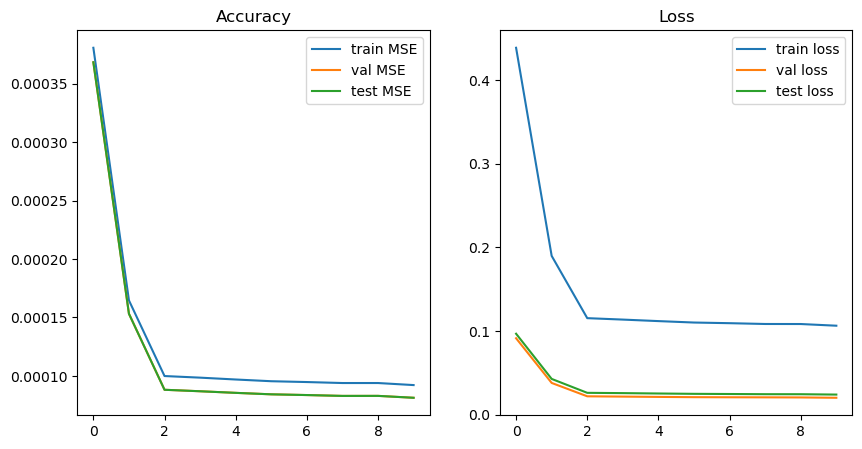

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size, num_steps, input_dim = sampleX.shape

model = RNNRegression(input_dim=input_dim, hidden_dim = 200, num_layers = 10)
model.to(device)

optim = torch.optim.Adam(model.parameters(), lr = 0.00001)
loss_fn = nn.MSELoss()

best_loss = float('inf')

history = defaultdict(list)

tune(model, train_dataloader, val_dataloader, test_dataloader, optim, loss_fn, device)

In [53]:
torch.save(model, 'rnn.regression.baseline.torch')